In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
np.random.seed(42)

In [7]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[crop_pad()])

In [8]:
mixup=0.2

In [9]:
loss_func = LabelSmoothingCrossEntropy()

In [10]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1., gamma=1.):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets, **kwargs):
#         CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-CE_loss)
#         F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
#         return F_loss.mean()
# loss_func = FocalLoss(gamma=3.)

In [11]:
alpha=0.99
mom=0.9
eps=1e-6

In [12]:
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [13]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [14]:
data = src.transform(tfms,size=(640)).databunch(bs=24).normalize()

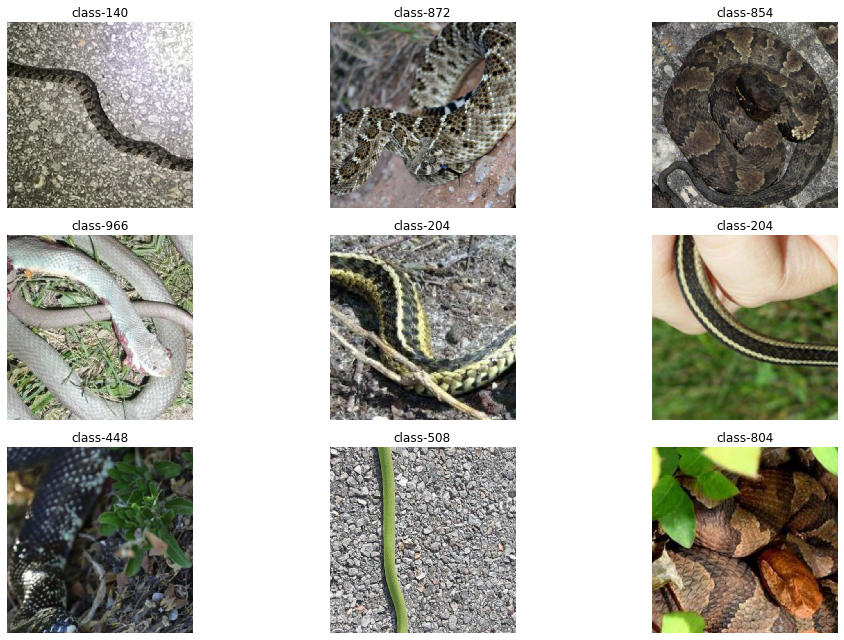

In [15]:
data.show_batch(3,figsize=(15,9))

In [16]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [17]:
learn= learn.mixup(alpha=mixup)

In [18]:
learn.bn_wd=False

In [19]:
learn.true_wd=True

In [21]:
learn.load('exp-11-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, mom

In [22]:
learn = learn.to_fp16(dynamic=True)

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


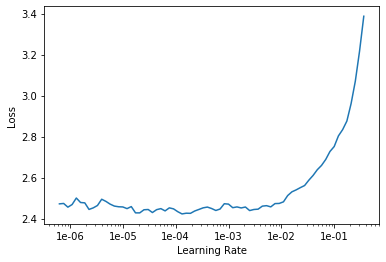

In [25]:
learn.recorder.plot()

In [ ]:
learn.fit(2,1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time


In [ ]:
learn.validate()

In [ ]:
learn.save('c_exp-11-round-1')